# *Lecture 18*

# Applications of Ordinary Differential Equations: Boundary-Value Problems

| |
|:---:|
|Selected Content [From **COMPUTATIONAL PHYSICS**, 3rd Ed, 2015](http://physics.oregonstate.edu/~rubin/Books/CPbook/index.html) <br>RH Landau, MJ Paez, and CC Bordeianu (deceased) <br>Copyrights: <br> [Wiley-VCH, Berlin;](http://www.wiley-vch.de/publish/en/books/ISBN3-527-41315-4/) and [Wiley & Sons, New York](http://www.wiley.com/WileyCDA/WileyTitle/productCd-3527413154.html)<br>  R Landau, Oregon State Unv, <br>MJ Paez, Univ Antioquia,<br> C Bordeianu, Univ Bucharest, 2015.<br> Support by National Science Foundation.|

# Introduction 

In the previous lectures, we discussed ordinary differential equations for physical systems.
These equations do not have specific solutions unless the initial conditions are specified.
(Technically, the solutions could be fixed at any specific time, but for physical systems it is usually the initial condition that is interesting.)

Do you recognize this physical application?
$$\begin{cases}
\frac{d^2 y}{dt^2} = -g \\
y(t=0) = 10 \\
v(t=0) = 0
\end{cases}$$

Now, instead of focusing on **initial-value problems**, we will shift the focus to **boundary-value problems**.
These have solutions fixed at the endpoints of the interval, either temporal or spatial.

## Simple Numerical Example

One example is the following system, with boundary conditions at endpoints of a time interval:

$$\begin{cases}
\frac{d^2 x}{dt^2} = -x \\
x(t=0) = 1 \\
x(t=\frac{\pi}{2}) = -3
\end{cases}$$

This cannot be shoehorned into our previously-used methods because we do not know the initial value for $dx/dt = v$, and we will not know it until we solve the system!

Of course, the general form of this simple system is known:
$$x(t) = c_1 \sin t + c_2 \cos t$$
It is clear that $c_2=1$ because of the initial condition.
Then $c_1 = -3$ because of the final condition.
In general we will not know the general form of the solution, but in this happy case we can write the analytic solution and plot it.

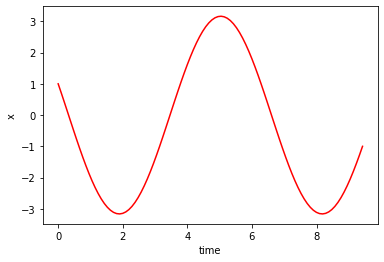

In [2]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0., 6.*np.pi/2., 100)
plt.plot(t, -3.*np.sin(t) + 1.*np.cos(t), 'r')
plt.xlabel('time')
plt.ylabel('x')
plt.show()

Before we dive into the details of the numerical methods, let's check an example of how to solve this "boundary-value problem" using the SciPy ODE solver libraries.
I am using the [`scipy.integrate.solve_bvp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#scipy.integrate.solve_bvp) function.
The other functions, like [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint), do not work because they expect a full set of initial conditions.

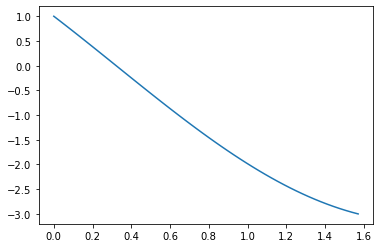

In [3]:
%matplotlib inline
# Example of solving boundary-value problem
import scipy.integrate as integrate

def f(t, x):
    return (x[1], -x[0])

# This is the "boundary value _residual_ function"
def bc(xa, xb):
    return (xa[0]-1., xb[0]-(-3.))

t = np.linspace(0., np.pi/2., 50)        # This is sometimes called the mesh, even in 1-D
x = np.zeros((2, t.size)) 
x[0,0] = 1.
x[0,-1] = -3.

result = integrate.solve_bvp(f, bc, t, x)
#print(result)

# The sol object (solution) is a continuous cubic spline that can be plotted directly
x_plot = result.sol(t)[0]
plt.plot(t, x_plot)
plt.show()

Note that this is only the first quarter-period of the oscillation we found above.  Now that we have the values, we can extend the function in time or space.

# Shooting Method

In the **shooting method**, we guess a solution, evolve it along its trajectory, and then check to see if the final boundary condition (BC) is satisfied.
That is, we check to see that $x(t=b) - BC(b)$ is close to 0.
Even if it is not exactly zero, we can stop when the agreement is "good enough."

The practical way to do this is to 
* Write the system of first-order differential equations
* Guess a value for the initial $dx/dt$.  (This is what is needed to evolve the system.)
* Evolve the system to the endpoint of the interval, using one of our ODE solvers
* Check the boundary condition (the value of $dx/dt$ at the endpoint $x=b$)

Repeating this procedure blindly is not a good idea!
We hope to use the residuals from the various attempts to converge to an acceptable solution.

Let's try to apply this to physical application in space instead of time: launch a projectile to hit the target at $y=-100$ at time $t=10$.

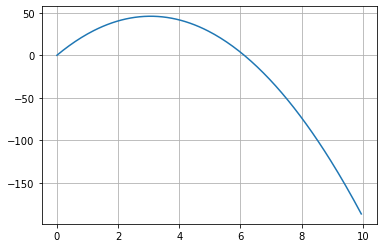

In [4]:
%matplotlib inline

# Example of the shooting method for projectile motion

import scipy.integrate as integrate

fReturn = np.zeros(2)

def derivs(state, t):
    fReturn[0] = state[1]                                                    
    fReturn[1] = -9.8
    return fReturn

dt = 0.05
t = np.arange(0.0, 10, dt)

# initial state
state = ([0., 30.])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
plt.plot(t, y[:, 0])
plt.grid()
plt.show()

By adjusting the initial conditions, we find the solution that satisfies the boundary conditions.  (What are the boundary conditions in this case?)

## Shooting Method Algorithm

Let's formalize our approach by defining the following system as an example:
$$\begin{cases}
x'' = f(t,x,x') \\
x(a) = \alpha \\
x(b) = \beta
\end{cases}$$

When we start to evolve a solution for $x$, we will need to pick an initial condition for $x'$.
If we set $x'(a) = z$, then the value of $x(b)$ is a function of $z$ -- call it $\phi(z)$. 
(The final condition depends on the initial condition.)

We will need to adjust the initial value $z$ until the final value is as desired ($\phi(z) = \beta$).

One way to do this is to use a linear interpolation between two results of initial guesses $\phi(z_1)$ and $\phi(z_2)$.
This corresponds to the secant method of finding the zero of $\phi(z) - \beta$!

Numerically, the "next guess" $z_3$ is given by
$$\frac{z_3 - z_2}{\beta - \phi(z_2)} = \frac{z_2 - z_1}{\phi(z_2) - \phi(z_1)}$$

with the solution
$$z_3 = z_2 + [\beta - \phi(z_2)] \left[ \frac{z_2 - z_1}{\phi(z_2) - \phi(z_1)}\right]$$

This process repeats until $\beta - \phi(z)$ is within the required precision.
A reasonable approach is to use large steps between $z$ values until the difference $\beta-\phi(z)$ switches sign, then reduce the step to find the zero.


## Example: Quantized Energy Levels in a Potential well 

If a particle of definite energy $E$ moving in one dimension experiences a symmetric potential
$V(x)$ centered at $x=0$, its wave function is determined by the ordinary differential equation known as the
time-independent Schrödinger equation (TISE)
$$
\frac{-\hbar^2} {2m} \frac{d^2\psi(x)}{dx^2} + V(x) \psi(x)
= E \psi(x)$$

Although we say we are solving for the energy $E$, in practice we solve
for the "wave vector" $\kappa$, where the two are related for bound states by:

$$\kappa^2 = -\frac{2m}{\hbar^2}E  =  \frac{2m}{\hbar^2}|E|$$

The Schrödinger equation now takes the form

$$\frac{d^2\psi(x)}{dx^2}  -  \frac{2m}{\hbar^2} V(x) \psi(x) = \kappa^2 \psi(x)$$

We have developed the methods that will solve this equation, once it has been broken into two first-order differential equations.
The solutions will not be complete without some information about the boundary conditions.
Because this is a time-independent equation, the interval is a spatial interval, not a temporal interval.

When our problem tells us that the particle is bound, this means that it
is confined to some finite region of space, which implies that $\psi(x)$
is normalizable. The only way for that to happen is if $\psi(x)$ decays
exponentially as $x\rightarrow \pm \infty$ (where the potential vanishes):

$$\psi(x) \rightarrow
\begin{cases}
     e^{-\kappa x}, & \mbox{for }\       x\rightarrow +\infty,\\
     e^{+\kappa x}, & \mbox{for }\              x\rightarrow -\infty.
\end{cases}$$

The
solution $\psi(x)$ must simultaneously satisfy the TISE and the boundary conditions.
Such a solution may exist only for certain values of $E$ or, equivalently, $\kappa$.
The ground-state energy corresponds
to the smallest (most negative) $E$ value that admits a solution. 
The ground-state wave
function (eigenfunction), which we must determine in order to find its
energy, must be nodeless and even (symmetric) about $x = 0$. The excited
states have higher (less negative) energies and wave functions that may
be odd (antisymmetric).

### Nucleon in a Box

Consider the finite square well potential

$$V(x) =\begin{cases}
 -V_0 = -83\,\text{MeV}, & \text{for }\ |x|\leq a= 2\,\text{fm},\\
    0, & \text{for } \   |x| \gt a=  2\,\text{fm},\end{cases}$$

where values of 83 MeV for the depth and 2 fm for the radius are typical for
nuclei. 
With this potential the constant factor in the Schrödinger equation becomes 

$$
\frac{2m}{\hbar^2} = \frac{2mc^2}{(\hbar c)^2} \simeq
\frac{2\times 940\,\text{MeV}}{(197.32\,\text{MeV fm})^2} =
0.0483\,\text{MeV}^{-1}\,\text{fm}^{-2}.$$

![image](Figures/Figure_9.1.png)

We need to find a suitable *curvature* for $\psi$ so that it can match both left and right exponentials.
The wave function computed by
integration in from the left is matched to the one computed by
integration in from the right (dashed curve in figure) at a point near the right
edge of the well.

**Always evolve the numerical solution from the "unphysical" region to the "physical" region.**

If you try to evolve the solution to the right in the right-edge region, you will find that the unwanted $e^{\kappa x}$ term makes the combined solution blow up.
Even though the coefficient for the $e^{\kappa x}$ solution is small, it is not exactly 0, and eventually it is overwhelmed by the exponential behavior.
In that case, the *unwanted* solution is the one that is increasing.

But when you evolve the solution to the right in the left-edge region, the *wanted* solution $e^{-\kappa x}$ is the one that is increasing.
This allows the combined solution to remain stable, under control of the coefficients.

## Eigenvalues via ODE Solver + Search

This solution of the eigenvalue problem combines the numerical solution
of the ordinary differential equation with a trial-and-error
search for a wave function that satisfies the boundary conditions.

1. Start on the very far **Left** at $x = -X_\text{max} \simeq
    -\infty$, where $X_\text{max}\gg a$. Because the potential
    $V = 0$ in this region, the analytic solution here is
    $e^{\pm \kappa x}$. 
    Accordingly, assume that the wave function
    there satisfies the left-hand boundary condition:

    $$
    \psi_L(x = -X_\text{max}) = e^{+\kappa x} = e^{-\kappa X_\text{max}}$$

2.  Use your favorite ODE solver to step $\psi_L(x)$ in
    toward the origin (to the right) from $x=-X_\text{max}$ until
    you reach the *matching radius* $x_\text{match}$. The exact
    value of this matching radius is not important, and our final
    solution should be independent of it. In this example, we match exactly at the
    right edge of the potential well.

3. Start at the extreme *right*, that is, at $x = +X_\text{max}
    \simeq +\infty$, with a wave function that satisfies the
    right-hand boundary condition:

    $$
    \psi_{R}(x = +\kappa X_\text{max}) = e^{-\kappa x} =      e^ {-\kappa
    X_\text{max} }$$

4.  Use your `rk4` ODE solver to evolve $\psi_R(x)$ in toward
    the origin (to the left) from $x=+X_\text{max}$ until you reach
    the *matching radius* $x_\text{match}$

5.  In order for probability and current to be continuous at
    $x=x_\text{match}$, $\psi(x)$ and $\psi'(x)$ must be
    continuous there. Requiring the ratio $\psi'(x)/\psi(x)$, called the
    *logarithmic derivative*, to be continuous there encapsulates both
    continuity conditions into a single condition and is independent of
    $\psi$’s normalization.
    In the language of our original boundary conditions, the BC residual is the difference.

6.  Although we do not know ahead of time which $E$ or $\kappa$ values are
    eigenvalues, we still need a starting value for the energy in order
    to use our ODE solver. The easiest way to start the solution is 
    with a guess for the energy. A good guess for ground-state energy
    would be a value a little bit above the bottom of the well,
    $E > −V_0$.
    
7.  Because it is unlikely that any guess will be correct, the left- and
    right-wave functions will not quite match at
    $x=x_\text{match}$. This is okay because we can
    use the amount of mismatch to improve the next guess. We measure how
    well the right and left wave functions match by calculating the
    difference in logarithmic derivatives

    $$
    \Delta (E,x) = \left. \frac{\psi'_L(x)/\psi_L(x) -
    \psi'_R(x)/\psi_R(x)}{\psi'_L(x)/\psi_L(x)
            + \psi'_R(x)/\psi_R(x) }\right|_{x=x_\text{match}},$$

    where the denominator is used to "normalize" the difference and avoid overly large or
    small numbers. Next we try a different energy, note how much
    $\Delta(E)$ has changed, and use this to deduce an intelligent guess at
    the next energy. The search continues until the left and right
    $\psi'/\psi$ match within some set tolerance that depends on the
    precision in energy desired.
    
In the following example, $x=x_\text{match}$ is at the left edge of the potential, which is not centered at 0.

<IPython.core.display.Javascript object>


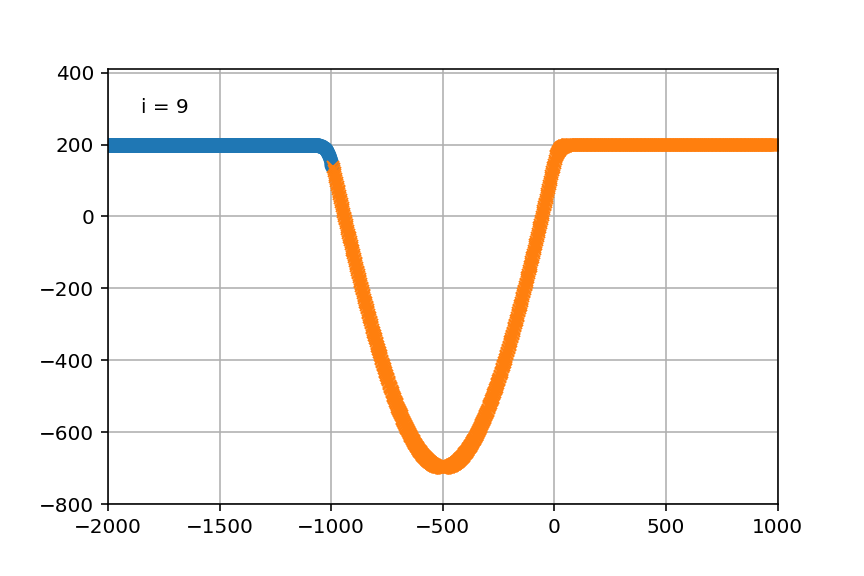

0 -17.077272727272728
1 -16.26590909090909
2 -15.860227272727272
3 -16.06306818181818
4 -15.961647727272727
5 -15.9109375
6 -15.936292613636363
7 -15.948970170454544
8 -15.955308948863635
9 -15.95213955965909
10 -15.950554865056816
11 -15.951347212357952
12 -15.95174338600852
13 -15.951941472833806
14 -15.952040516246448
Final eigenvalue E =  -15.952090037952768
iterations, max =  15


In [5]:
%matplotlib notebook

""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# QuantumEigen.py:             Finds E and psi via rk4 + bisection
 
# mass/((hbar*c)**2)= 940MeV/(197.33MeV-fm)**2 =0.4829, well width=20.0 fm
# well depth 10 MeV, Wave function not normalized.  

import matplotlib.animation as animation
from numpy import zeros, sqrt

count_max = 100
Lwf = zeros((count_max,2,502))
Rwf = zeros((count_max,2,997))
eps       = 1E-3                                             # Precision
n_steps   = 501 
E         = -17.0                                              # E guess
h         = 0.04
count_max = 100
Emax      = 1.1*E                                              # E limits
Emin      = E/1.1            

def f(x, y, F, E):
    F[0] = y[1]
    F[1] = -(0.4829)*(E-V(x))*y[0]

def V(x):
    if (abs(x) < 10.):  return (-16.0)                        # Well depth
    else:               return (0.)

def rk4(t, y, h, Neqs, E):
    F  = zeros((Neqs))
    ydummy = zeros((Neqs))
    k1 = zeros((Neqs))
    k2 = zeros((Neqs))
    k3 = zeros((Neqs))
    k4 = zeros((Neqs))
    f(t, y, F, E)
    for i in range(0,Neqs):
        k1[i] = h*F[i]
        ydummy[i] = y[i] + k1[i]/2.
    f(t + h/2., ydummy, F, E)
    for i in range(0,Neqs):
        k2[i] = h*F[i]
        ydummy[i] = y[i] + k2[i]/2.
    f(t + h/2., ydummy, F, E)
    for i in range(0,Neqs):
        k3[i]=  h*F[i]
        ydummy[i] = y[i] + k3[i]
    f(t + h, ydummy, F, E);
    for i in range(0,Neqs):
        k4[i]=h*F[i]
        y[i]=y[i]+(k1[i]+2*(k2[i]+k3[i])+k4[i])/6.0

def diff(E, h):
    y = zeros((2),float)
    i_match = n_steps//3                                # Matching radius
    nL = i_match + 1  
    y[0] = 1.E-15;                                      # Initial left wf
    y[1] = y[0]*sqrt(-E*0.4829)    
    for ix in range(0,nL + 1):
        x = h * (ix  -n_steps/2)
        rk4(x, y, h, 2, E)
    left = y[1]/y[0]                                    # Log  derivative
    y[0] = 1.E-15;                    #  slope for even;  reverse for odd
    y[1] = -y[0]*sqrt(-E*0.4829)                        # Initialize R wf
    for ix in range( n_steps,nL+1,-1):
        x = h*(ix+1-n_steps/2)
        rk4(x, y, -h, 2, E)
    right = y[1]/y[0]                                    # Log derivative
    return( (left - right)/(left + right) )

def plot(E, h, i):                            # Repeat integrations for plot
    x = 0. 
    n_steps = 1501                                  # # integration steps
    y = zeros((2),float)
    yL = zeros((2,505),float) 
    i_match = 500                                        # Matching point
    nL = i_match + 1;  
    y[0] = 1.E-40                                      # Initial left wf
    y[1] = -sqrt(-E*0.4829) *y[0]
    for ix in range(0,nL+1):                          
        yL[0][ix] = y[0]
        yL[1][ix] = y[1]
        x = h * (ix -n_steps/2)
        rk4(x, y, h, 2, E)
    y[0] = -1.E-15                      # - slope: even;  reverse for odd
    y[1] = -sqrt(-E*0.4829)*y[0]
    j=0
    for ix in range(n_steps -1,nL + 2,-1):          # right wave function
        x = h * (ix + 1 -n_steps/2)                        # Integrate in
        rk4(x, y, -h, 2, E)
        Rwf[i,0,j] = 2.*(ix + 1 -n_steps/2)-500.0
        Rwf[i,1,j] = y[0]*35e-9 +200
        j +=1
    x = x-h              
    normL = y[0]/yL[0][nL]
    j=0
    # Renormalize L wf & derivative
    for ix in range(0,nL+1):
        x = h * (ix-n_steps/2 + 1) 
        y[0] = yL[0][ix]*normL 
        y[1] = yL[1][ix]*normL
        Lwf[i,0,j] = 2.*(ix  -n_steps/2+1)-500.0
        Lwf[i,1,j] = y[0]*35e-9+200                      # Factor for scale
        j +=1

        
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2000, 1000), ylim=(-800, 410))
ax.grid()

lwf_curve, = ax.plot([], [], 'o-', lw=2)   
rwf_curve, = ax.plot([], [], 'x-', lw=2)
ilabel_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    lwf_curve.set_data([],[])
    rwf_curve.set_data([],[])
    ilabel_text.set_text('i')
    return lwf_curve, rwf_curve, ilabel_text
    
def animate(i):
    lwf_curve.set_data(Lwf[i,0,:], Lwf[i,1,:])
    rwf_curve.set_data(Rwf[i,0,:], Rwf[i,1,:])
    ilabel_text.set_text('i = %d' % i)
    return lwf_curve, rwf_curve, ilabel_text
        
for count in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diff = diff(E, h) 
    if (diff(Emax, h)*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if ( abs(Diff)  <  eps ):     break
    plot(E, h, count)
    print(count, E)
        
ani = animation.FuncAnimation(fig, animate, np.arange(1, count),
                                         interval=1000, blit=True, init_func=init)

print("Final eigenvalue E = ",E)
print("iterations, max = ",count)



# Numerov Method

The Numerov method is a specialized method for ODE’s not containing any first derivatives (such
as our Schrödinger equation). 
While this algorithm is not as general as
`rk4`, it is of ${\cal O}(h^6)$ and thus speeds up the calculation by
providing additional precision.
The basic idea of the Numerov method is to focus attention on the second derivative.

We start by rewriting the Schrödinger equation in the generic second-order
form, without a first-order derivative term.

$$
\frac{d^2\psi}{dx^2} +k^2(x)\psi    = 0, \quad
 k^2(x)  = \frac{2m} {\hbar^2}
\begin{cases}
 E+V_0, & \mbox{for}\           |x| \lt a ,\\
        E, & \mbox{for}\    |x| \gt a ,
        \end{cases}$$

where $k^2 = −\kappa^2$ for bound states. The trick in the Numerov method
is to get extra precision in the second derivative by taking advantage of there
being no first derivative $d\psi/dx$. 
We start with the Taylor expansions
of the wave functions,

$$\begin{align}
\psi(x+h) &\ \simeq\  \psi(x)+h\psi^{(1)}(x)+  \frac{h^2} { 2}\psi^{(2)}(x)
+ \frac{h^3}{3!}\psi^{(3)}(x)+ \frac{h^4} {4!}\psi^{(4)}(x) + .
\\
\psi(x-h) &\ \simeq\ \psi(x)-h\psi^{(1)}(x)+  \frac{h^2} {
2}\psi^{(2)}(x)- \frac{h^3} { 3!}\psi^{(3)}(x)+ \frac{h^4} { 4!}\psi^{(4)}(x) + .
 \end{align}$$

where $\psi^{(n)}$ signifies, as before, the $n$th derivative
$d^n \psi/dx^n$. 
Because the expansion of $\psi(x-h)$
has odd powers of $h$ appearing with negative signs, all odd
powers cancel when we add $\psi(x+h)$ and $\psi(x-h)$ together:

$$\begin{align}
\psi(x+h)+\psi(x-h)  & \simeq \ 2\psi(x)+h^2\psi^{(2)}(x)+\displaystyle\frac{h^4} { 12}\psi^{(4)}(x) +{\cal O}(h^6),   \\
\Rightarrow \quad \psi^{(2)}(x) & \simeq
\frac{\psi(x+h)+\psi(x-h)-2\psi(x)} { h^2} \\
&  -
\frac{h^2}{12}\psi^{(4)}(x) +{\cal O}(h^4)
 \end{align}$$

To obtain an algorithm for the second derivative, we eliminate the
fourth-derivative term by applying the operator $1+\frac{h^2}{12}
\frac{d^2}{dx^2}$ to the Schrödinger equation:

$$\tag*{9.17}
\psi^{(2)}(x)+ \frac{h^2} {12}\psi^{(4)}(x)+k^2(x)\psi+
\frac{h^2}{12} \
 \frac{d^2} { dx^2}[k^2(x)\psi^{(4)}(x)]=0.$$

We eliminate the $\psi^{(4)}$ terms by substituting the derived
expression for the $\psi^{(2)}$:

$$
\frac{\psi(x+h)+\psi(x-h)-2\psi(x) } { h^2} +k^2(x)\psi(x)
 + \frac{h^2}{12} \ \frac{d^2 } { dx^2 }[k^2(x)\psi(x)] \simeq 0.$$

Now we use a central-difference approximation for the second derivative
of $k^2 (x) \psi(x)$:

$$
 h^2    \frac{d^2 [k^2(x)\psi(x)] } { dx^2}  \simeq
    [(k^2\psi)_{x+h} -(k^2\psi)_x]+ [(k^2\psi)_{x-h} -(k^2\psi)_x]$$

This gives the general Numerov algorithm:

$$
\psi(x+h)   \simeq \frac{2 [1-
\frac{5}{12}h^2k^2(x) ]\psi(x) - [1+ \frac{h^2} {12} k^2(x-h) ]
\psi(x-h)} { 1+h^2 k^2(x+h)/12}$$

We see that the Numerov algorithm uses the values of $\psi$ at the two
previous steps $x$ and $x−h$ to move $\psi$ forward to $x + h$. To
step backward in $x$, we need only to reverse the sign of $h$.

1.9126748577245383e-37
1.3370425869574915e-06
5.510890224226373e-05
0.0006605069904361445
0.0027103213459093727
0.0006199160200480525
0.6745540246812008
-0.6010199578588143
1.82935676293375
0.9382087525184463
0.8178053586167349
1.1218253693512965
1.0476074806467566
1.020889212658963
0.9899258893153287
0.994792351362087
1.002627335895562
0.9986922295643083
0.99934341370492
0.9996710306025927


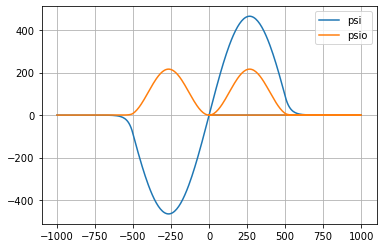

[[-1.00000000e+03 -9.93333333e+02 -9.86666667e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -6.62785919e-06 -1.35410547e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[-0.00096519 -0.00096519 -0.00096519 ... -0.00096519 -0.00096519
 -0.00096519]


In [4]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# QuantumNumerov:        Quantum BS via Numerov ODE solver + search

# This assumes hbar = 1, m = 1, 

psi = np.zeros((2, 1000))
psio = np.zeros((2, 1000))

dl    = 1e-8                      # very small interval to stop bisection
ul    = np.zeros(1501)
ur    = np.zeros(1501)
k2l   = np.zeros(1501)                        # k**2 left wavefunc
k2r   = np.zeros(1501)                         
n     = 1501
nl    = n
nr    = n
m     = 5                                           # plot every 5 points
imax  = 100 
xl0   = -1000;   xr0   =  1000                    # leftmost, rightmost x  
h     = 1.0*(xr0-xl0)/(n-1.)            
amin  = -0.01; amax  = -0.00085                            # root limits
e     = amin                                            # Initial E guess
de    = 0.01
ul[0] = 0.0; ul[1] = 0.00001; ur[0] = 0.0; ur[1] = 0.00001     
im = 500                                                    # match point
istep=0

def V(x):                                                   # Square well
    if (abs(x)<=500):
        v = -0.001                            
    else:
        v = 0
    return v

def setk2():                                                       #  k2  
    for i in range(0,n):         
       xl = xl0+i*h
       xr = xr0-i*h
       k2l[i] = e-V(xl)
       k2r[i] = e-V(xr)

def numerov (n,h,k2,u):                             # Numerov algorithm  
    b=(h**2)/12.0                          
    for i in range(1, n-1):  
      u[i+1] = (2*u[i]*(1-5*b*k2[i])-(1.+b*k2[i-1])*u[i-1])/(1+b*k2[i+1])

setk2()
numerov (nl, h, k2l, ul)                                       # Left psi
numerov (nr, h, k2r, ur)                                      # Right psi
fact= ur[nr-2]/ul[im]                                             # Scale
for i  in range (0,nl): ul[i] = fact*ul[i]
f0 = (ur[nr-1]+ul[nl-1]-ur[nr-3]-ul[nl-3])/(2*h*ur[nr-2])    #  Log deriv

def normalize():    
    asum = 0
    for i in range( 0,n):                     
        if i > im :
            ul[i] = ur[n-i-1]
            asum = asum+ul[i]*ul[i]
    asum        = np.sqrt(h*asum); 
    j=0
    for i in range(0,n,m):                   
        xl        = xl0 + i*h
        ul[i]     = ul[i]/asum                 # wave function normalized
        psi[0][j]  = xl                                   # plot psi
        psi[1][j]  = 10000.0*ul[i]       # vertical line for match of wvfs
        psio[0][j] = xl                                     # plot psi
        psio[1][j] = 1.0e5*ul[i]**2
        j +=1
        
while abs(de) > dl and istep < imax :               # bisection algorithm
    e1 = e                                                  
    e  = (amin+amax)/2                                     
    for i in range(0,n):  
        k2l[i] = k2l[i] + e-e1             
        k2r[i] = k2r[i] + e-e1
        nl = im+2
        nr = n-im+1;
    numerov (nl,h,k2l,ul)                              # New wavefuntions
    numerov (nr,h,k2r,ur)               
    fact = ur[nr-2]/ul[im]
    print(fact)
    for i in range(0,nl):  ul[i] = fact*ul[i] 
    f1 = (ur[nr-1]+ul[nl-1]-ur[nr-3]-ul[nl-3])/(2*h*ur[nr-2]) # Log deriv
    if f0*f1 < 0:                               # Bisection localize root
        amax = e
        de = amax - amin
    else:
         amin = e
         de = amax - amin
         f0 = f1
    normalize()     
    istep = istep + 1

plt.figure()
plt.plot(psi[0], psi[1], label='psi')
plt.plot(psio[0], psio[1], label='psio')
plt.legend()
plt.grid()
plt.show()
print(psi)
print(k2l)

# Orbital Mechanics

All we need for orbital mechanics in the solar system is 
the force between
a planet of mass $m$ and the sun of mass $M$ is

$$F^{(g)} = - \frac{G mM} { r^2}$$

where $r$ is the planet-CM distance, $G$ is the universal gravitational
constant, and the attractive force lies along the line connecting the
planet and the sun. 

The equation of motion is still

$$\mathbf{F} = m \mathbf{a} = m \frac{d^2 \mathbf{x}}{dt^2}$$

with the force components given by

$$\begin{align}
F_x & = F^{(g)} \cos \theta = F^{(g)}\frac{x} { r} = F^{(g)}\frac{x} {
\sqrt{x^2+y^2}},\\ F_y & = F^{(g)} \sin \theta = F^{(g)}\frac{y} { r} =
F^{(g)}\frac{y} { \sqrt{x^2+y^2}}
\end{align}$$

The equation of motion can be rewritten as usual as two simultaneous second-order
ODE’s:

$$\frac{d^2 x}{dt^2} = -GM \frac{x}{r^3}, \quad \frac{d^2 y}{dt^2} = -GM \frac{y}{r^3}$$

The solution to these equations can be calculated with the following steps:

1. Calculate the units, for example, $GM = 1$, and define initial conditions

2.  Modify your ODE solver program to solve the first-order differential equations.

3.  Establish that you use small enough time steps so that the orbits
    are closed and fall upon themselves.


<IPython.core.display.Javascript object>


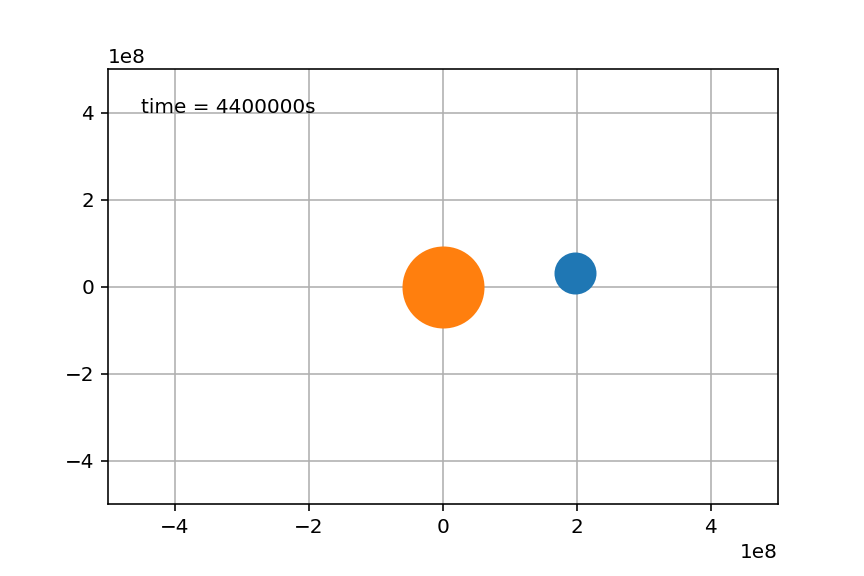

In [7]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import matplotlib.animation as animation

d = 3.844e08 # meters
T = 27.322 * 24. * 3600. # seconds
m_earth = 5.976e24 # kilograms
m_moon = 7.35e22 # kilograms
G = 6.67e-11 # N m^2 / kg
    
def derivs(state, t):
    # state = (x, v_x, y, v_y)
    # We'll assume Earth is fixed at (0,0)
    x = state[0]
    y = state[2]
    out = np.zeros_like(state)
    d_E = np.sqrt(pow(x-0, 2) + pow(y-0, 2))
    
    out[0] = state[1]
    out[1] = -G*m_earth*(x-0)/pow(d_E,3)
    out[2] = state[3]
    out[3] = -G*m_earth*(y-0)/pow(d_E,3)
    return out

# create a time array
dt = 50000 # seconds
time_interval = np.arange(0.0, 2*T, dt)

# state with 4 elements of moon motion: (x, v_x, y, v_y)
state = (2e8, 0, 0, 1.5e3) # medium Earth orbit

moon_positions = integrate.odeint(derivs, state, time_interval)

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-5e8, 5e8), ylim=(-5e8, 5e8))
ax.grid()

moon_marker, = ax.plot([], [], 'o-', markersize=20)
earth_marker, = ax.plot([], [], 'o-', markersize=40)
time_template = 'time = %.0fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    moon_marker.set_data([], [])
    earth_marker.set_data([], [])
    time_text.set_text('')
    return earth_marker, moon_marker, time_text

def animate(i):
    earth_marker.set_data( 0, 0)
    moon_marker.set_data(  moon_positions[i][0],  moon_positions[i][2])
    time_text.set_text(time_template % (i*dt))
    return earth_marker, moon_marker, time_text

ani = matplotlib.animation.FuncAnimation(fig, animate, np.arange(1, len(time_interval)),
                                         interval=200, blit=True, init_func=init)